In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import tensorflow as tf
import tensorflow_datasets as tfds
import time

from sklearn.datasets import make_regression
from utils.utils import make_writer

os.environ["TF_KERAS"]='1'
%matplotlib inline

# Most common bugs II

## Resources

- [Understanding LSTM networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
- [Batch normalization explained](https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c)
- [See-RNN package](https://github.com/OverLordGoldDragon/see-rnn)
- [Gradient clipping](http://proceedings.mlr.press/v28/pascanu13.html)

## Switching between train/test modes when using batch norm or dropout

In [18]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0
# Add a channels dim
x_train = tf.expand_dims(x_train.astype('float32'), axis=-1)
x_test = tf.expand_dims(x_test.astype('float32'), axis=-1)

In [27]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [20]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(32, 3, activation='relu')
        self.flatten = tf.keras.layers.Flatten()
        self.dropout = tf.keras.layers.Dropout(rate=0.5)
        self.d1 = tf.keras.layers.Dense(128, activation='relu')
        self.d2 = tf.keras.layers.Dense(10)
            

    def call(self, x):
        x = self.conv1(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)

# Create an instance of the model
model = MyModel()

In [21]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

In [22]:
train_loss = tf.keras.metrics.Mean(name='train_loss')

test_loss_correct = tf.keras.metrics.Mean(name='test_loss')

test_loss_wrong = tf.keras.metrics.Mean(name='test_loss')

In [23]:
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)

In [24]:
def test_step_correct(images, labels):
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss_correct(t_loss)

In [15]:
def test_step_wrong(images, labels):
    predictions = model(images, training=True)
    t_loss = loss_object(labels, predictions)

    test_loss_wrong(t_loss)

In [26]:
EPOCHS = 5
writer_wrong = make_writer(os.path.join('summaries'), 'training_mode_bug/wrong_modes')
writer_correct = make_writer(os.path.join('summaries'), 'training_mode_bug/correct_modes')


for epoch in range(EPOCHS):

    train_loss.reset_states()
    test_loss_wrong.reset_states()
    test_loss_correct.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)
    
    for test_images, test_labels in test_ds:
        test_step_wrong(test_images, test_labels)
        test_step_correct(test_images, test_labels)
    
    with writer_wrong.as_default():
        tf.summary.scalar('Test Loss', test_loss_wrong.result(), step=epoch)
    
    with writer_correct.as_default():
        tf.summary.scalar('Test Loss', test_loss_correct.result(), step=epoch)

    message = (
        f'Epoch: {epoch + 1}, Test Loss Wrong: {test_loss_wrong.result()},'
        f'Test Loss Correct: {test_loss_correct.result()}'
    )
    print(message)   

Creating a tensorboard directory: summaries/training_mode_bug/wrong_modes
Creating a tensorboard directory: summaries/training_mode_bug/correct_modes
Epoch: 1, Test Loss Wrong: 231.7429962158203,Test Loss Correct: 203.6964111328125
Epoch: 2, Test Loss Wrong: 190.036865234375,Test Loss Correct: 178.4427032470703
Epoch: 3, Test Loss Wrong: 180.25958251953125,Test Loss Correct: 170.1095428466797
Epoch: 4, Test Loss Wrong: 194.4781494140625,Test Loss Correct: 187.61427307128906
Epoch: 5, Test Loss Wrong: 249.5968017578125,Test Loss Correct: 235.17352294921875


## Numerical instabilities

### Exploding and vanishing gradients

### A bit of theory:

- $X$ - input
- $o$ - output
- $L$ - number of layers in the network
- $l$ - layer $l$ with the transormation $f_l$ and corresponding weights $W^l$ and the hidden variable $h^l$

 $$h^l = f_l(h^{l-1})$$ $$o = f_L \circ ... \circ f_1(X)$$
 
If all $h_l$ and the input are vectors, one can write the gradient of $o$ with respect to any set of parameters $W^l$ as:

$$\partial_{W^l}o = \partial_{h^{L-1}}{h^L} ... \partial_{h^{l}}h^{l+1} \partial_{W^{l}}h^l   $$

### Vanishing gradients:

- Historically sigmoid was used as an activation function.
- It resembles a thresholding function and was appealing, since neural nets were inspired by biological neural networks, where biological neurons either fire fully or not at all.

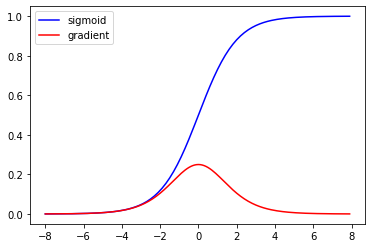

In [10]:
x = tf.Variable(tf.range(-8.0, 8.0, 0.1))

with tf.GradientTape() as tape:
    y = tf.nn.sigmoid(x)

grad = tape.gradient(y, x).numpy()
x = x.numpy()
y = y.numpy()
    
plt.plot(x, y, 'b', label='sigmoid')
plt.plot(x, grad, 'r', label='gradient') 
plt.legend()
plt.show()

- Gradients vanish for both big and small inputs
- Multiply many layers and if the inputs are not near zero, then a gradient can vanish
- Gradient cut off at some layer --> difficult to build deep nets

### Exercise:

- What's the standard solution for this specific instance of the problem?
- Make a similar plot for the solution.
- What is the problem of the standard solution? Can we improve it? Please, plot it.

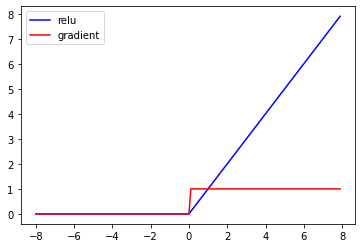

In [17]:
x = tf.Variable(tf.range(-8.0, 8.0, 0.1))

with tf.GradientTape() as tape:
    y = tf.nn.relu(x)

grad = tape.gradient(y, x).numpy()
x = x.numpy()
y = y.numpy()
    
plt.plot(x, y, 'b', label='relu')
plt.plot(x, grad, 'r', label='gradient') 
plt.legend()
plt.show()

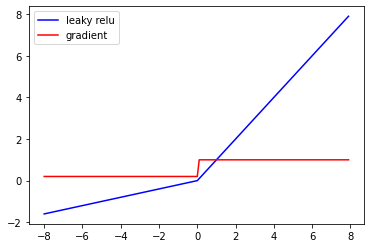

In [25]:
x = tf.Variable(tf.range(-8.0, 8.0, 0.1))

with tf.GradientTape() as tape:
    y = tf.nn.leaky_relu(x)

grad = tape.gradient(y, x).numpy()
x = x.numpy()
y = y.numpy()
    
plt.plot(x, y, 'b', label='leaky relu')
plt.plot(x, grad, 'r', label='gradient') 
plt.legend()
plt.show()

### Vanishing gradients in RNNs



- See-rnn package helps debug and analyze RNNs. 

In [31]:
from tensorflow.keras.layers import Input, LSTM, SimpleRNN
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from see_rnn import get_gradients, features_1D, features_2D

def make_model(rnn_layer, batch_shape, units):
    ipt = Input(batch_shape=batch_shape)
    x   = rnn_layer(units, activation='tanh', return_sequences=True)(ipt)
    out = rnn_layer(units, activation='tanh', return_sequences=False)(x)
    model = Model(ipt, out)
    model.compile(Adam(4e-3), 'mse')
    return model
    
def make_data(batch_shape):
    return np.random.randn(*batch_shape), \
           np.random.uniform(-1, 1, (batch_shape[0], units))

def train_model(model, iterations, batch_shape):
    x, y = make_data(batch_shape)
    for i in range(iterations):
        model.train_on_batch(x, y)
        print(end='.')  # progbar
        if i % 40 == 0:
            x, y = make_data(batch_shape)

units = 16
batch_shape = (32, 100, 2*units)

model_rnn = make_model(SimpleRNN, batch_shape, units)
model_lstm = make_model(LSTM, batch_shape, units)
train_model(model_rnn, 300, batch_shape)
train_model(model_lstm, 300, batch_shape)

x, y  = make_data(batch_shape)
grads_all_rnn  = get_gradients(model_rnn, 1, x, y)
grads_all_lstm  = get_gradients(model_lstm, 1, x, y) 

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

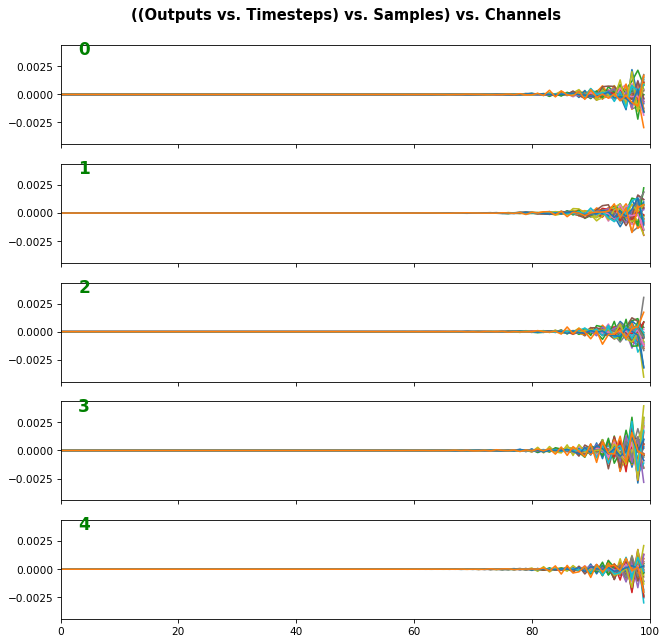

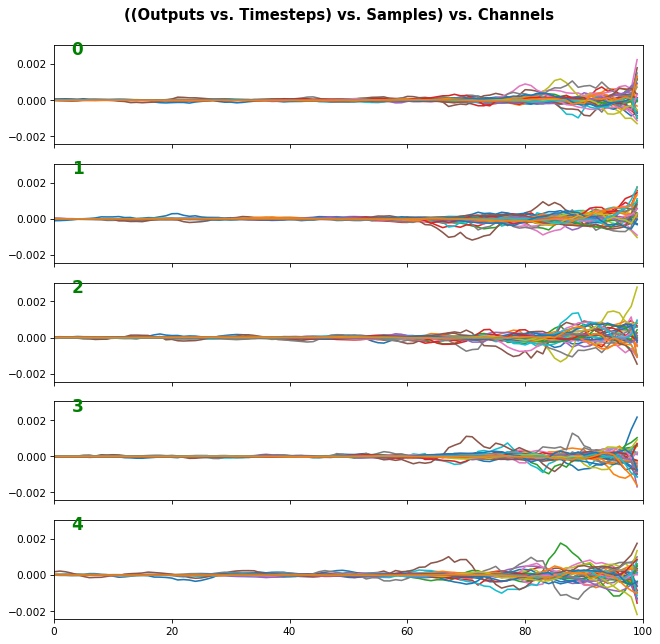

In [33]:
# Plot RNN VS LSTM 1D
features_1D(grads_all_rnn[:, :, :5], n_rows=5, show_xy_ticks=[1,1])
features_1D(grads_all_lstm[:, :, :5], n_rows=5, show_xy_ticks=[1,1])
plt.show()

#### Exploding gradients and gradient clipping



In [44]:
M = tf.random.normal((4, 4))
print(f'A single matrix \n \n {M.numpy()}')
for i in range(100):
    M = tf.matmul(M, tf.random.normal((4, 4)))

print(f'\nAfter multiplying 100 matrices \n \n {M.numpy()}')

A single matrix 
 
 [[ 0.01651425  0.784566   -0.2058465  -0.16268806]
 [-1.5680819  -1.4078673  -0.5255653   1.1256984 ]
 [-1.5682017  -0.9935413   2.4634926   0.47556058]
 [ 0.14332195 -1.5058492   0.36354986 -1.0209935 ]]

After multiplying 100 matrices 
 
 [[ 1.3639834e+23  8.9984055e+22  3.1079780e+22  1.5699710e+22]
 [ 5.9535915e+23  3.9276743e+23  1.3565879e+23  6.8526970e+22]
 [-2.9200700e+24 -1.9264144e+24 -6.6536815e+23 -3.3610559e+23]
 [ 1.6279691e+23  1.0739959e+23  3.7094975e+22  1.8738231e+22]]


#### Gradient clipping

- Clip a gradient by norm:
    - $ \textbf{g} \gets min\left(1, \frac{\theta}{||\textbf{g}||}\textbf{g} \right)$
    - For example: $$\textbf{g}= [-2, 3, 6]$$ $$\theta = 5$$ $$||\textbf{g}|| = 7$$ $$\textbf{g} \gets [-2, 3, 6]\cdot \frac{5}{7}$$
    
- Clip gradient by value:
    - If $g_i < \theta_1$, then $g_i \gets \theta_1$ and $g_i > \theta_2$, then $g_i \gets \theta_2$
    - For example: $$\textbf{g}= [-2, 3, 10]$$ $$\theta_1 = 0, \theta_2 = 5$$  $$ \textbf{g} \gets [0, 3, 5]$$

    
- Clip gradient by global norm:
    - Rescales a list of tensors so that the total norm of the vector of all their norms does not exceed a threshold.
    - For example: $$\textbf{g}_1 = [-2, 3, 6]$$ $$\textbf{g}_2= [-4, 6, 12]$$ $$\theta = 14$$ $$||\textbf{g}_1|| = 7$$ $$||\textbf{g}_2|| = 14$$ $$\textbf{g}_1 \gets [-2, 3, 6]\cdot \frac{14}{\sqrt{7^2 + 14^2}}$$ $$\textbf{g}_2 \gets [-4, 6, 12]\cdot \frac{14}{\sqrt{7^2 + 14^2}} $$
    

In [48]:
# generate regression dataset
X, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=1)
# split into train and test
n_train = 500
trainX, testX = X[:n_train, :].astype('float32'), X[n_train:, :].astype('float32')
trainy, testy = y[:n_train].astype('float32'), y[n_train:].astype('float32')

# Creat tf.Datasets 
train_dataset = tf.data.Dataset.from_tensor_slices((trainX, trainy)).shuffle(trainX.shape[0]).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((testX, testy)).shuffle(testX.shape[0]).batch(32)

In [49]:
class RegressorNet(tf.keras.Model):
    def __init__(self, input_shape, optimizer):
        super(RegressorNet, self).__init__()
        
        self.loss_object = tf.keras.losses.MeanSquaredError()
        self.optimizer = optimizer
        self.regressor = tf.keras.Sequential([
            tf.keras.layers.Input(input_shape),
            tf.keras.layers.Dense(25, activation='relu', kernel_initializer='he_uniform', name='dense_1'),
            tf.keras.layers.Dense(1, activation='linear', name='out')
        ])
    
    def summary(self):
        self.regressor.summary()
    
    def call(self, X):
        return self.regressor(X)
    
    def get_loss(self, X, y_true):
        y_pred = self(X)
        l2_loss = self.loss_object(y_true, y_pred)
        return l2_loss
    
    def grad_step(self, X, y_true):
        with tf.GradientTape() as tape:
            loss = self.get_loss(X, y_true)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return loss, gradients

In [50]:
# Specify an optimizer and an instance of the model
optimizer = tf.keras.optimizers.SGD(0.01, 0.9)
model_non_clipped = RegressorNet(input_shape=trainX.shape[1], optimizer=optimizer)
# Show summary
model_non_clipped.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 25)                525       
_________________________________________________________________
out (Dense)                  (None, 1)                 26        
Total params: 551
Trainable params: 551
Non-trainable params: 0
_________________________________________________________________


In [51]:
# Create loss objects for calculation of the mean loss across batches
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

In [66]:
def train(model, epochs, train_dataset, test_dataset, save_dir):
    
    writer = make_writer(os.path.join('summaries'), save_dir)
    
    for epoch in range(0, epochs + 1):
        
        train_loss.reset_states()
        test_loss.reset_states()

    
        if epoch % 10 == 0:
            print('Epoch {} is running...'.format(epoch))
        
        for X, y in train_dataset:
            # Gradient update step
            loss_train, gradients = model.grad_step(X, y)
            train_loss(loss_train)
            
        for X, y in test_dataset:
            # Gradient update step
            loss_test = model.get_loss(X, y)
            test_loss(loss_test)
        
        if epoch % 10 == 0:
            print(f'Train loss: {train_loss.result()}')

        # Tensorboard
        with writer.as_default():
            tf.summary.scalar('Test loss', test_loss.result(), step=epoch)
            tf.summary.scalar('Train loss', train_loss.result(), step=epoch)
            
            for layer_number, layer in enumerate(model.trainable_variables):
                tf.summary.histogram(layer.name, gradients[layer_number], step=epoch, buckets=1)    


In [67]:
train(model_non_clipped, 100, train_dataset, test_dataset, 'exploding_grads/no_clipping/')

Creating a tensorboard directory: summaries/exploding_grads/no_clipping/
Epoch 0 is running...
Train loss: nan
Epoch 10 is running...
Train loss: nan
Epoch 20 is running...
Train loss: nan
Epoch 30 is running...
Train loss: nan
Epoch 40 is running...
Train loss: nan
Epoch 50 is running...
Train loss: nan
Epoch 60 is running...
Train loss: nan
Epoch 70 is running...
Train loss: nan
Epoch 80 is running...
Train loss: nan
Epoch 90 is running...
Train loss: nan
Epoch 100 is running...
Train loss: nan


### Exercise

- Implement gradient clipping by norm OR by value OR by global norm in a new class RegressorNetClipped.
- Plot gradient updates with clipping.
- Experiment with the different clippings.
- Which one do you think is the best clipping strategy? Why?

A threshold is a parameter. In most of the cases it's a small number, usually around 1.
However, one can experiment with that, bigger numbers speed up learning, but too big of a threshold can make it unstable.
Another rule of thumb to choose a threshold is to monitor an average norm of the gradients for a big number of updates, then set the threshold to 5-10 times the value of that average.

Hint: check `tf.clip_by_value`, `tf.clip_by_norm`, `tf.clip_by_global_norm`

In [62]:
class RegressorNetClipped(tf.keras.Model):
    def __init__(self, input_shape, optimizer):
        super(RegressorNetClipped, self).__init__()
        
        self.loss_object = tf.keras.losses.MeanSquaredError()
        self.optimizer = optimizer
        self.regressor = tf.keras.Sequential([
            tf.keras.layers.Input(input_shape),
            tf.keras.layers.Dense(25, activation='relu', kernel_initializer='he_uniform', name='dense_1'),
            tf.keras.layers.Dense(1, activation='linear', name='out')
        ])
    
    def summary(self):
        self.regressor.summary()
    
    def call(self, X):
        return self.regressor(X)
    
    def get_loss(self, X, y_true):
        y_pred = self(X)
        l2_loss = self.loss_object(y_true, y_pred)
        return l2_loss
    
    def grad_step(self, X, y):
        with tf.GradientTape() as tape:
            loss = self.get_loss(X, y)
        gradients = tape.gradient(loss, self.trainable_variables)
        gradients = tf.clip_by_global_norm(gradients, 2.0)[0]
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return loss, gradients

In [63]:
opt = tf.keras.optimizers.SGD(lr=0.01, momentum=0.9)
model_clipped = RegressorNetClipped(input_shape=trainX.shape[1], optimizer=opt)

In [68]:
train(model_clipped, 100, train_dataset, test_dataset, 'exploding_grads/clipped/')

Creating a tensorboard directory: summaries/exploding_grads/clipped/
Epoch 0 is running...
Train loss: 0.9777857661247253
Epoch 10 is running...
Train loss: 1.1750473976135254
Epoch 20 is running...
Train loss: 0.9900419116020203
Epoch 30 is running...
Train loss: 1.1643744707107544
Epoch 40 is running...
Train loss: 0.9254682660102844
Epoch 50 is running...
Train loss: 1.0104999542236328
Epoch 60 is running...
Train loss: 0.8963991403579712
Epoch 70 is running...
Train loss: 0.7692965269088745
Epoch 80 is running...
Train loss: 0.9714847207069397
Epoch 90 is running...
Train loss: 0.7604863047599792
Epoch 100 is running...
Train loss: 0.9094566106796265


## OOM errors

### Common issues and causes

- Too big a tensor:
    - Too large a batch size for your model 
    - Too many fully connected layers
- Too much data:
    - Loading a too big dataset into memory instead of using, e.g. tf.data queue loading
    - Allocating to large a buffer for dataset creation
- Duplicating operations:
    - Memory leak due to creating multiple models at the same time
    - Repeatedly creating an operation (e.g. in a function that gets called many times)
- Other processes:
    - Other processes taking GPU memory

Some of you will work with images. Here is an easy way to load images off disk batch by batch, so you won't run out of memory.

**Use tf.keras.preprocessing**

```python
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
```

- This code assumes that the images are stored in a directory with sub-directories for each label.
- The output is tf.data.Dataset object